# Learning outcomes

When you've worked through the exercise in this notebook, you'd have

* built and evaluated SVM and logistic regression models using a standard software library;

* explored selection of the best hyperparameters for your models.

# Objectives


* To explore an existing dataset
> This week, we'll use a subset of the UK Met dataset. You can read more about the UK Met dataset here: https://rmets.onlinelibrary.wiley.com/doi/10.1002/gdj3.78. We will use the 60km-resolution data for 2010 to 2022.

* To apply support vector machine (SVM) and logistic regression algorithms from Week 3 mini-videos to automatic detection of the number of days of ground frost based on other weather variables.

# Section 1 - Explore the UK Met (60km, 2010-2022) dataset

See the dataset on the Week 3 page for the module, on Canvas (see 'Week 3 Lab Dataset' on the page). The file is named c*urated_data_1month_2010-2022_nonans.csv*.
* What does each variable in the dataset represent?
* What is the distribution of the number of days of ground frost in the dataset? What of for the number of days of snow?
* What does this tell you about the data?
* What else can you tell about the data?


**Solution**

* See the headers in the data file and the information in the *Metadata_VARIABLES.xlsx* file on the Week 3 canvas page for what each variable represents. The variables in the dataset consists of:
  * the x and y coordinate IDs of the sampled locations,
  * the month and year serial numbers,
  * the sea pressure level, air temperature, wind speed, vapour pressure, humidity, rainfall, sunshine duration, and
  * number of days of ground frost and snow.
* The distribution for the number of days of ground frost and snow is:
  * Ground frost mean - 7.94 (days per month)
  * Ground frost max - 28.02 (days per month)
  * Ground frost min - 0.00077 (days per month)
  * Ground frost standard deviation - 6.95 (days per month)
  * Snow mean - 0.896 (days per month)
  * Snow max - 23.95 (days per month)
  * Snow min - 0 (days per month)
  * Snow standard deviation - 2.24 (days per month)
* The above distribution suggests a strong skew to the left. Open the dataset using Microsoft Excel and use the software to plot a histogram of each of the two variables. The plots will show that the lowest levels of ground frost and snow are overrepresented in the dataset while there is minimal representation for the highest levels of the variables.
* It is not surprising that most of the year in the UK has minimal ground frost and snow.
* A scatter plot of each of the two variables will also show cyclic variations over time. This is not surprising given seasonal changes to weather.

# Section 2 - Load the dataset





1. You need to first download the data before you can get started. Download from the Week 3 page for the module, on Canvas (see 'Week 3 Lab Dataset' on the page). The file you download will be named *curated_data_1month_2010-2022_nonans.csv*.

2. Then, use the file menu in Google Colab to upload the file to your Colab directory. Once upload is complete, you should be able to see the file on the listed contents of your Colab directory.

3. You can now run the code in the cell below to load the data.

In [1]:
import csv
import numpy



data_file_full_path = "/content/curated_data_1month_2010-2022_nonans.csv"

data_as_list = []

# load the dataset
with open(data_file_full_path) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')

    row_count = 0
    for row in csv_reader:

      if row_count > 0:
        data_as_list.append([float(val) for val in row])
      row_count += 1
data = numpy.array(data_as_list)

# check its shape
print("\n The dataset has shape: "+str(data.shape))


# get features and labels from the data
# based on the objectives (see the Objectives section)
feat_col = [5, 6, 7, 8, 9, 10]
ground_frost_col = 4


feats = data[:, feat_col]
ground_frost_label = data[:, ground_frost_col]



# take a peek
print("\n A peek at the dataset features: \n"+str(feats))
print("\n A peek at the ground frost labels: \n"+str(ground_frost_label))




 The dataset has shape: (10296, 13)

 A peek at the dataset features: 
[[8.93698275e+01 1.02266536e+03 6.45115642e+01 9.12500556e+00
  6.45810733e+00 6.72744772e+00]
 [8.94462109e+01 1.02270800e+03 5.74868117e+01 8.81473207e+00
  5.88191052e+00 6.23064828e+00]
 [8.93435447e+01 1.02243684e+03 6.82935149e+01 8.70098793e+00
  4.62830127e+00 6.29080656e+00]
 ...
 [8.78370293e+01 1.00645706e+03 1.38800195e+01 6.23638415e+00
  4.96064026e+00 1.85626301e+00]
 [8.88116315e+01 1.00662248e+03 2.05853162e+01 6.08591654e+00
  4.93635497e+00 7.75835354e-01]
 [8.27601516e+01 1.00593830e+03 1.05309193e+01 6.72653639e+00
  8.38081942e+00 3.54509758e+00]]

 A peek at the ground frost labels: 
[ 9.84928987 10.85267889 12.97189949 ... 21.7275541  23.77582838
 17.35386163]


# Section 3 - Split into training, validation, and test sets

In [2]:
from sklearn.model_selection import train_test_split

all_ids = numpy.arange(0, feats.shape[0])

random_seed = 1

# First randomly split the data into 70:30 to get the training set
train_set_ids, rem_set_ids = train_test_split(all_ids, test_size=0.3, train_size=0.7,
                                 random_state=random_seed, shuffle=True)


# Then further split the remaining data 50:50 into validation and test sets
val_set_ids, test_set_ids = train_test_split(rem_set_ids, test_size=0.5, train_size=0.5,
                                 random_state=random_seed, shuffle=True)


train_data = feats[train_set_ids, :]
train_ground_frost_labels = ground_frost_label[train_set_ids]


val_data = feats[val_set_ids, :]
val_ground_frost_labels = ground_frost_label[val_set_ids]


test_data = feats[test_set_ids, :]
test_ground_frost_labels = ground_frost_label[test_set_ids]


# Section 4 - Scale the features

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()



scaler.partial_fit(train_data)
scaled_train_data = scaler.transform(train_data)


scaler.partial_fit(val_data)
scaled_val_data = scaler.transform(val_data)


scaler.partial_fit(test_data)
scaled_test_data = scaler.transform(test_data)


# Section 5 - Train and evaluate a SVM regression model (with hyperparameter optimization)

* Have a read of the documentation for the software library that implements the SVM for regression: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html.

* Adapt the code below to optimize the regularization parameter C (aka 'box constraint').

**Solution**

In [6]:

from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
import sys

#--- Use the validation set to optimize the box constraint hyperparameter ---
#--- based on grid search method ---

# set the range of hyperparameters to search from
c_options = [0.1, 1.0, 10.0]
# initialize the optimal box constraint value
best_c = 0.1
# initialize the performance of the optimal box constraint value
best_c_perf = sys.float_info.max

# for each box constraint in the set of values to search
# training a SVM model and evaluate it
# if the performance obtained is better than the currrent 'best_c_perf'
# set the box constraint as the current optimal
for c in c_options:
  #print("\n for c="+str(c)+"...")
  model_SVM = LinearSVR(C=c, random_state=random_seed, loss='squared_epsilon_insensitive')
  model_SVM.fit(scaled_train_data, train_ground_frost_labels)
  val_pred_SVM = model_SVM.predict(scaled_val_data)
  val_mse_SVM = mean_squared_error(val_ground_frost_labels, val_pred_SVM)

  if val_mse_SVM < best_c_perf:
    best_c = c
    best_c_perf = val_mse_SVM

print('\n The optimal c for this data is: '+str(best_c))


# use the optimized box constraint to train the final model
model_SVM = LinearSVR(C=best_c, random_state=random_seed, loss='squared_epsilon_insensitive')
model_SVM.fit(scaled_train_data, train_ground_frost_labels)

# evaluate the trained model using the test set
test_pred_SVM = model_SVM.predict(scaled_test_data)
mse_SVM = mean_squared_error(test_ground_frost_labels, test_pred_SVM)
print('\n The test mean squared error (MSE) is: '+str(mse_SVM))




 The optimal c for this data is: 10.0

 The test mean squared error (MSE) is: 4.649875477719985


# Section 6 - Train and evaluate a LR classification model

* Use the information from Section 1 to split the ground frost label values into 4 classes.
* Apply this to create classification labels for the labels in Section 2.
* Use the classification labels to train and evaluate a logistic regression model using the Scikit Learn library (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).


**Solution**

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from copy import deepcopy

# to obtain an even distribution of data instances across classes
# split based on distribution of given data (use the quartile information)
# and take into consideration that the max possible number of days of ground frost
# is 31 days since the longest month in the year has that number of days

ground_frost_label_class = deepcopy(ground_frost_label)
numpy.place(ground_frost_label_class, ground_frost_label_class<=0.95, 0)
numpy.place(ground_frost_label_class, numpy.logical_and(ground_frost_label_class>0.95, ground_frost_label_class<=6.87), 1)
numpy.place(ground_frost_label_class, numpy.logical_and(ground_frost_label_class>6.87, ground_frost_label_class<=13.87), 2)
numpy.place(ground_frost_label_class, ground_frost_label_class>13.87, 3)

print("\n A peek at the classification ground frost labels: \n"+str(ground_frost_label_class))


train_ground_frost_labels_class = ground_frost_label_class[train_set_ids]
val_ground_frost_labels_class = ground_frost_label_class[val_set_ids]
test_ground_frost_labels_class = ground_frost_label_class[test_set_ids]



model_LR = LogisticRegression(penalty='l2', random_state=random_seed)
model_LR.fit(scaled_train_data, train_ground_frost_labels_class)


test_pred_LR = model_LR.predict(scaled_test_data)
acc_LR = accuracy_score(test_ground_frost_labels_class, test_pred_LR)
print('\n The test accuracy is: '+str(acc_LR))





 A peek at the classification ground frost labels: 
[2. 2. 2. ... 3. 3. 3.]

 The test accuracy is: 0.7993527508090615


# Section 7 - Evaluate using other classification metrics


 The F1 scores for each of the classes are: [0.87626263 0.73572377 0.73232323 0.85258964]

 The average F1 score is: 0.7992248179001168



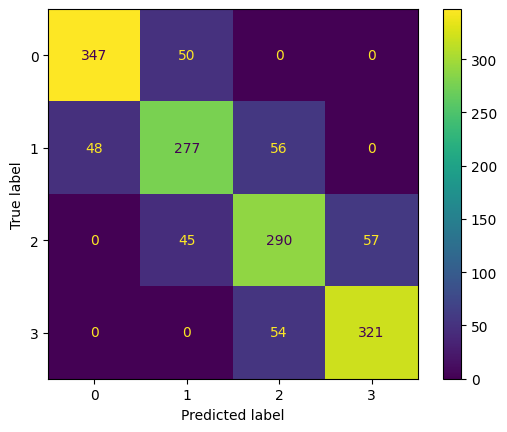

In [8]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# F1 score similar to accuracy in that it ranges between 0 and 1
# We will look at this metric in Week 6
avg_f1_score_LR = f1_score(test_ground_frost_labels_class, test_pred_LR, average='macro')
f1_scores_LR = f1_score(test_ground_frost_labels_class, test_pred_LR, average=None)
print('\n The F1 scores for each of the classes are: '+str(f1_scores_LR))
print('\n The average F1 score is: '+str(avg_f1_score_LR))
print()

# Confusion shows the misclassification
# We will look at this metric in Week 6
confusion_matrix_SVM = confusion_matrix(test_ground_frost_labels_class, test_pred_LR)
disp = ConfusionMatrixDisplay(confusion_matrix_SVM)
disp.plot()
plt.show()
